### Segmentation of Mammographic Mass 

Import Libraries
##### importing necessary libraries including TensorFlow/Keras for building the model, PIL for image processing, and Matplotlib for visualization.

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
# Define the path to the dataset
# Define the path to the dataset
dataset_path = "C:/Users/HP/OneDrive/Desktop/Karatu/Breast_Cancer/Breast_Cancer_Segmentation/Dataset-20240803T175638Z-001/Dataset" # Adjust the path to yours

# Function to load images and masks from a directory
def load_images_and_masks(dir_path):
    # Initialize a dictionary to store data about images and masks
    data = {'category': [], 'type': [], 'image_path': [], 'mask_path': [], 'width': [], 'height': []}
    
    # Loop through each category (benign and malignant)
    for category in ['benign', 'malignant']:
        # Walk through the directory structure
        for root, _, files in os.walk(os.path.join(dir_path, category)):
            # Loop through each file in the current directory
            for file in files:
                # Check if the file is an image (MLO.png)
                if file.endswith('MLO.png'):
                    # Construct the full path to the image
                    image_path = os.path.join(root, file)
                    # Construct the corresponding mask path by replacing 'MLO.png' with 'CC.png'
                    mask_path = image_path.replace('MLO.png', 'CC.png')
                    # Check if the corresponding mask file exists
                    if os.path.exists(mask_path):
                        # Open the image using PIL
                        image = Image.open(image_path)
                        # Append the category (benign/malignant) to the data dictionary
                        data['category'].append(category)
                        # Append the type (train/test/validation) to the data dictionary
                        data['type'].append(os.path.basename(dir_path))
                        # Append the image path to the data dictionary
                        data['image_path'].append(image_path)
                        # Append the mask path to the data dictionary
                        data['mask_path'].append(mask_path)
                        # Append the width of the image to the data dictionary
                        data['width'].append(image.width)
                        # Append the height of the image to the data dictionary
                        data['height'].append(image.height)
    
    # Convert the data dictionary to a Pandas DataFrame and return it
    return pd.DataFrame(data)

In [3]:
# Load images and masks from the dataset
train_df = load_images_and_masks(os.path.join(dataset_path, 'train'))
test_df = load_images_and_masks(os.path.join(dataset_path, 'test'))
validation_df = load_images_and_masks(os.path.join(dataset_path, 'validation'))

In [4]:
# Combine all data into a single DataFrame
df = pd.concat([train_df, test_df, validation_df], ignore_index=True)

In [5]:
# Directory and file structure analysis
print("Number of images and masks in each category:")
print(df.groupby(['type', 'category']).size().unstack(fill_value=0))

Number of images and masks in each category:
category    benign  malignant
type                         
test            58         70
train          281        287
validation      40         23


this is the number of images and masks in each category (benign and malignant) for the train, test, and validation sets.

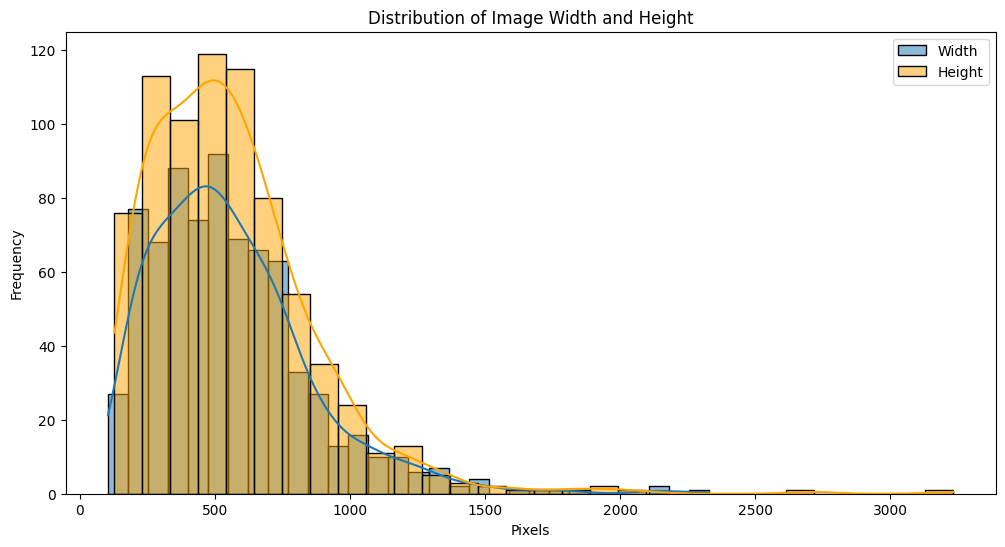

In [6]:
# EDA: Image size and aspect ratio distribution
df['aspect_ratio'] = df['width'] / df['height']

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='width', bins=30, kde=True, label='Width')
sns.histplot(data=df, x='height', bins=30, kde=True, color='orange', label='Height')
plt.title('Distribution of Image Width and Height')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()





#### Width Distribution:

#### Key Observation 
Represented in blue.
Shows the frequency of different image widths in the dataset.
The curve over the bars represents the kernel density estimate (KDE) for width, giving a smooth approximation of the distribution.
Height Distribution:

Represented in orange.
Shows the frequency of different image heights in the dataset.
The orange curve is the KDE for height, providing a smooth estimate of the height distribution.
Key Observations:
Distribution Shape:
Both widths and heights have a **positively skewed distribution, meaning most of the images are concentrated in the lower pixel ranges, with fewer images having higher pixel dimensions.
There are some outliers with very large width and height values, as indicated by the long tail on the right side of the histogram.
Common Dimensions:

Most images have widths and heights around the 500-600 pixel range, as indicated by the peaks in the histogram.
The height distribution has a higher peak compared to width, suggesting that images more frequently have a certain height.
KDE Curves:

The KDE curves help visualize the underlying distribution of widths and heights more smoothly than the histograms alone.
The KDE curves confirm the skewness and the concentration of image dimensions around certain pixel values.

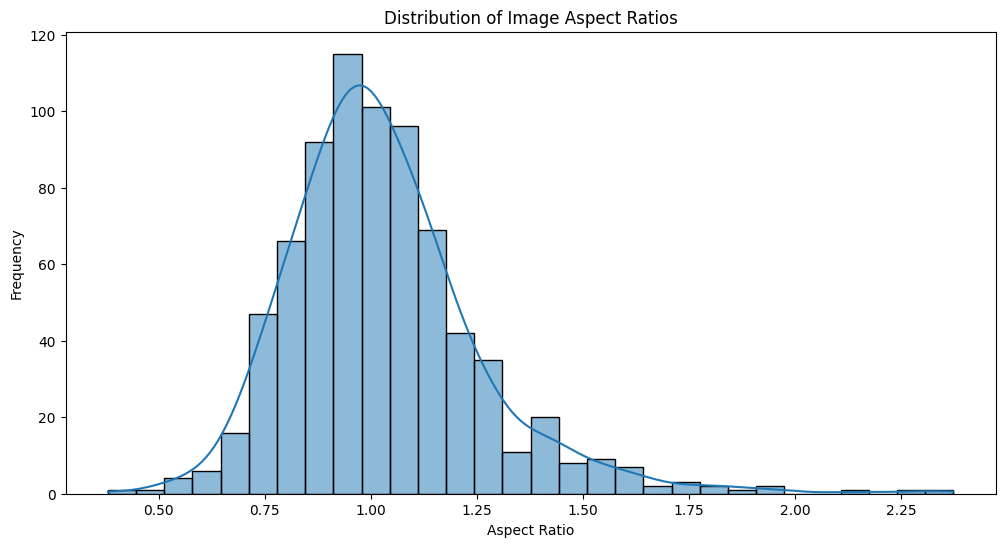

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='aspect_ratio', bins=30, kde=True)
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

#### ASPECT RATIO IMAGE

This image is a histogram showing the distribution of image aspect ratios in your dataset. The aspect ratio is defined as the ratio of the width to the height of an image.

##### Key Observations:
Distribution Shape:
The distribution is approximately normal (bell-shaped) with a peak around an aspect ratio of 1.0.
This suggests that most images in the dataset are roughly square, with their width and height being almost equal.
Peak at 1.0:

The highest frequency of images occurs around an aspect ratio of 1.0, indicating that a large number of images have equal or nearly equal width and height.
Range of Aspect Ratios:

The aspect ratios range from approximately 0.5 to 3.0, showing that while many images are square, there are also a significant number of images that are more rectangular in shape (both wider and taller than they are square).
The right tail of the distribution extends to around 3.0, indicating the presence of images that are much wider than they are tall.
KDE Curve:

The Kernel Density Estimate (KDE) curve overlays the histogram, providing a smooth approximation of the aspect ratio distribution.
The KDE curve confirms the normal-like distribution centered around an aspect ratio of 1.0.

Displaying sample images and masks from the training set:


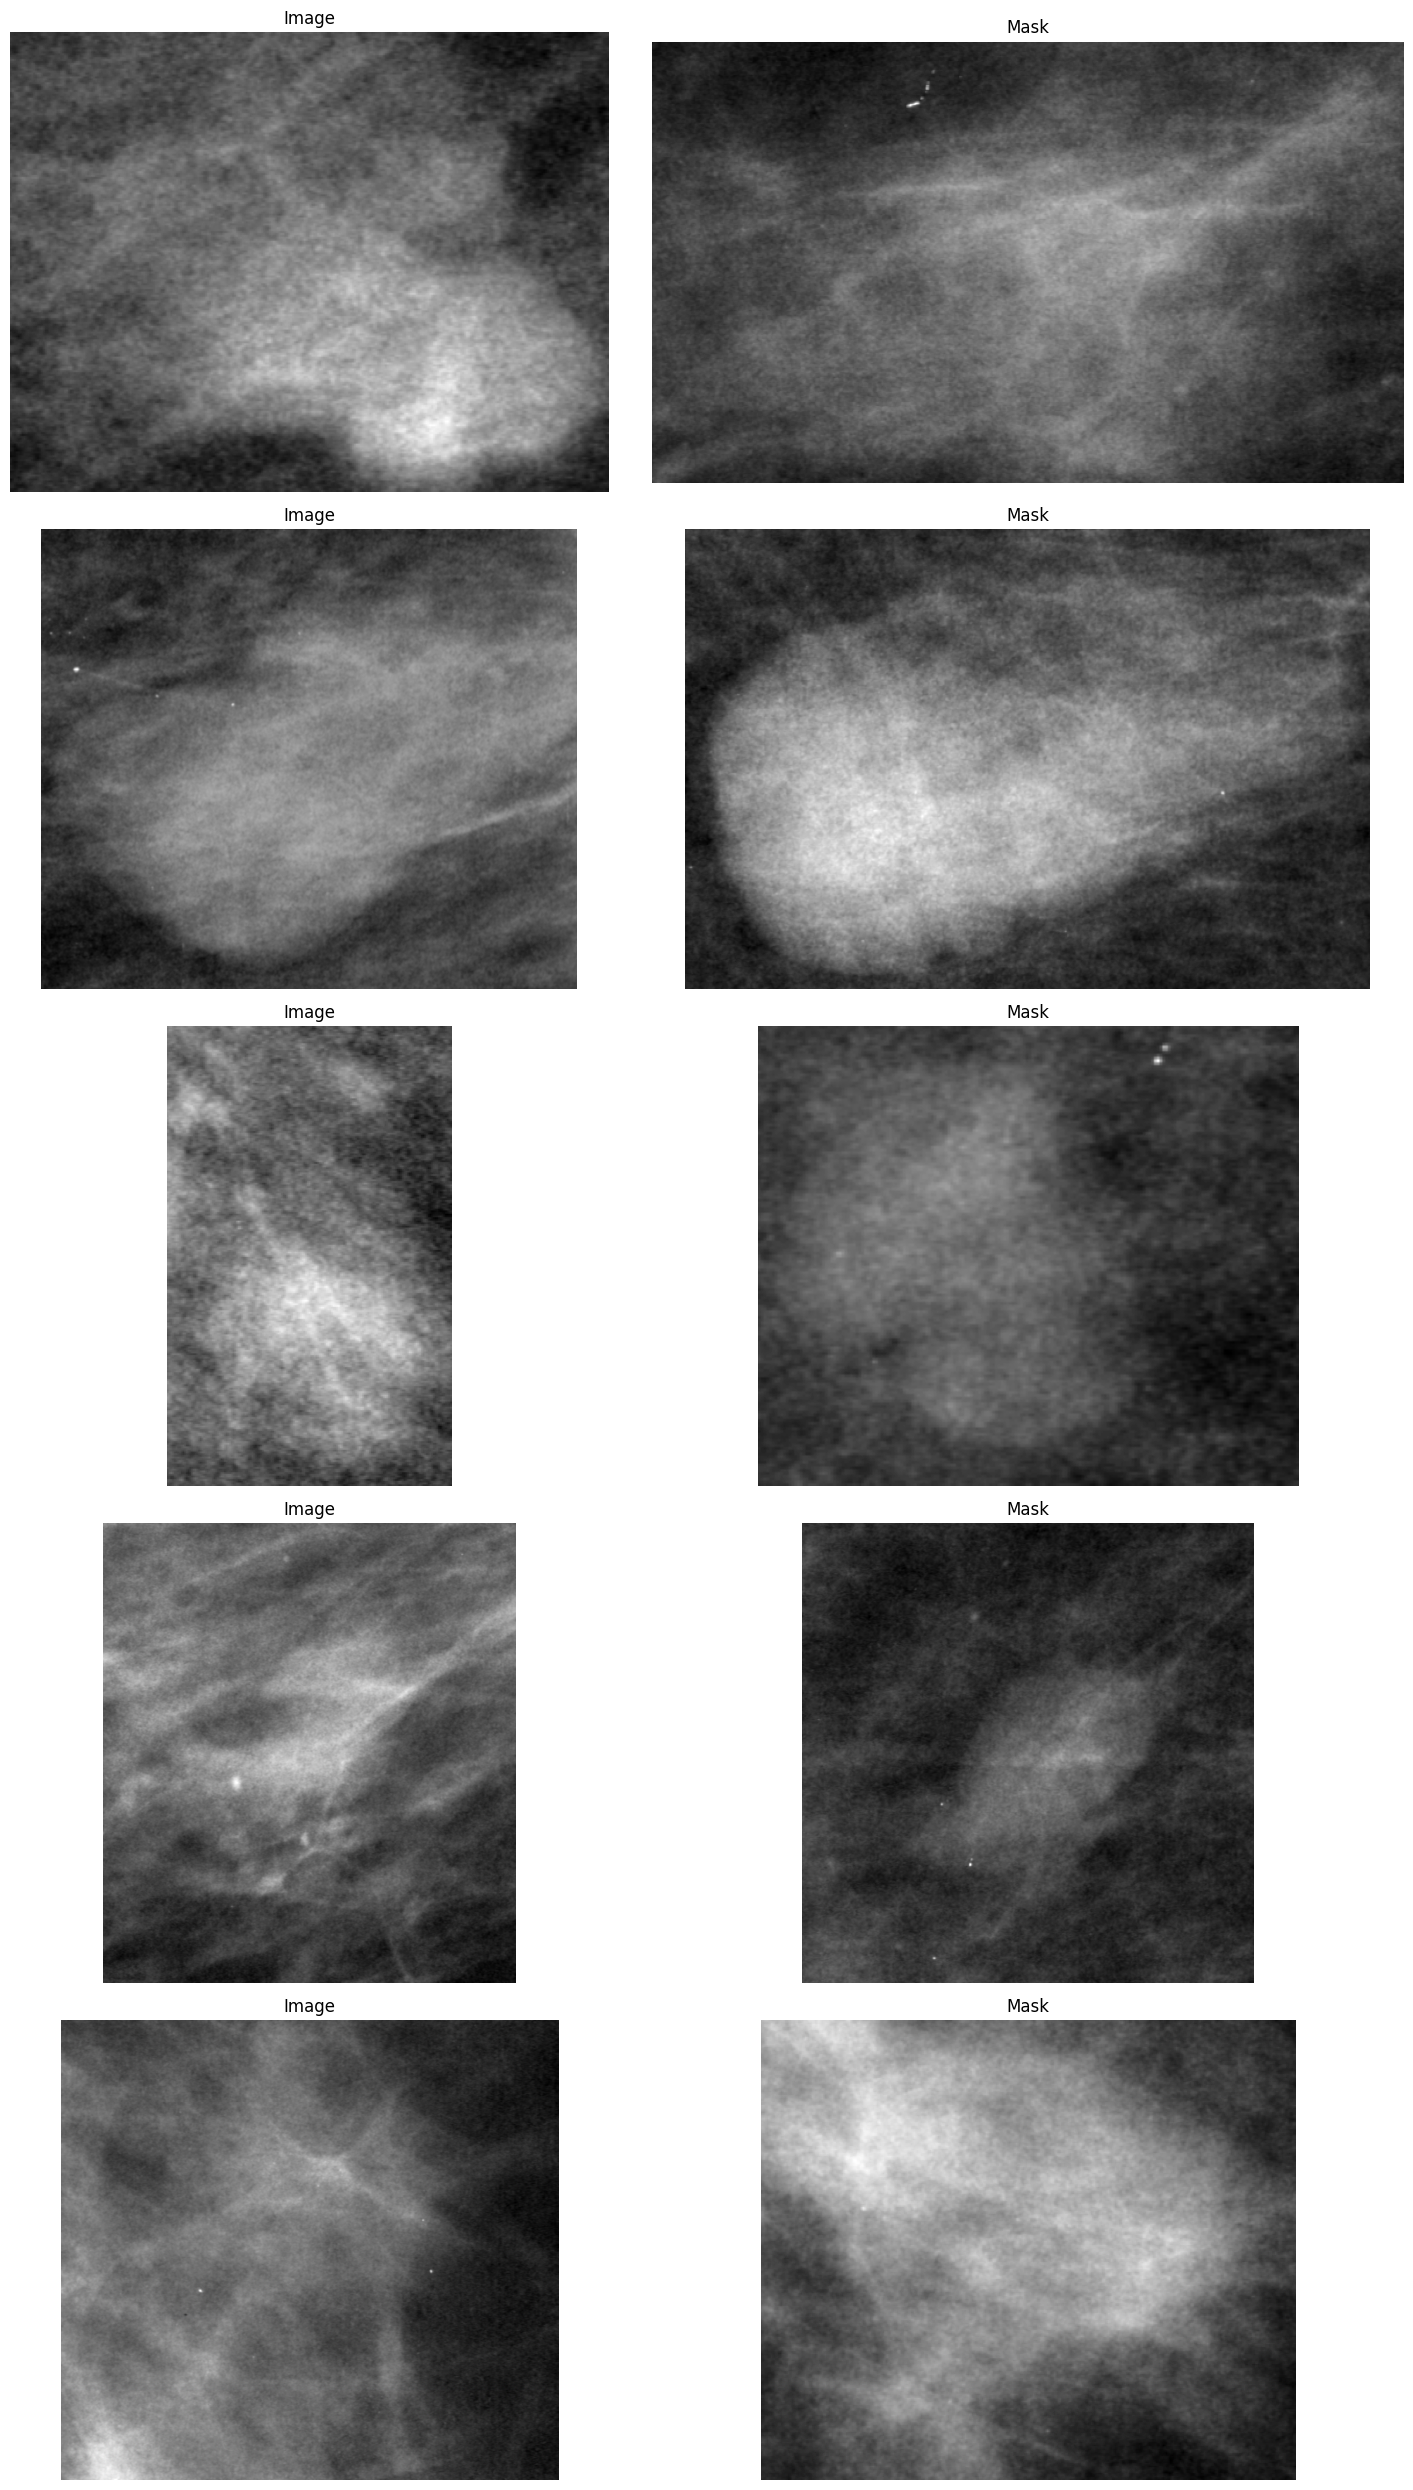

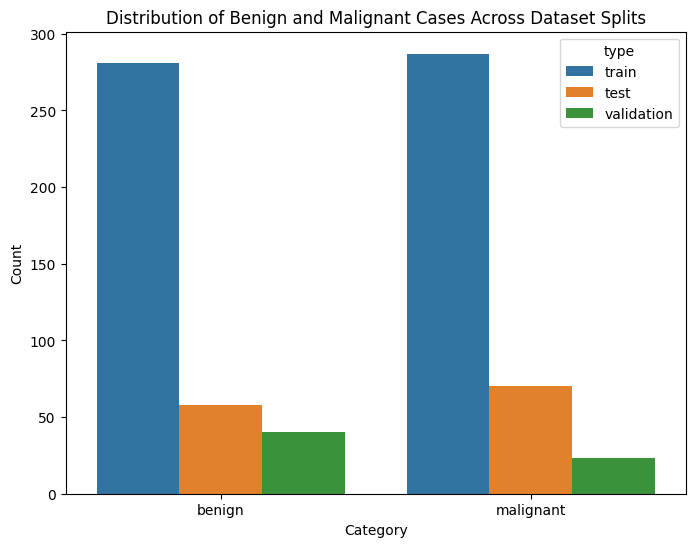

In [8]:

# EDA: Visualization of sample images and masks
def display_images_and_masks(images, masks, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        image = Image.open(images[i])
        mask = Image.open(masks[i])

        # Display image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(image, cmap='gray')
        plt.title('Image')
        plt.axis('off')

        # Display mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Displaying sample images and masks from the training set:")
display_images_and_masks(train_df['image_path'], train_df['mask_path'])

# EDA: Class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='category', hue='type')
plt.title('Distribution of Benign and Malignant Cases Across Dataset Splits')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


### the downward part of this code is yet to be exercuted 

### Define U-Net Model
The U-Net architecture consists of a contracting path (encoder) and an expansive path (decoder) that allows precise localization.

In [2]:
### the unet structure 
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


### Compile the Model
compiling the model with an appropriate loss function and optimizer. For segmentation tasks, binary_crossentropy is commonly used for binary segmentation.

In [ ]:
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


### Data Preprocessing
functions to preprocess the data. This involves loading images, resizing them, and normalizing pixel values.

In [ ]:
def preprocess_images(images):
    processed_images = []
    for image_path in images:
        image = Image.open(image_path).convert('L')
        image = image.resize((256, 256))
        image = np.array(image) / 255.0
        image = np.expand_dims(image, axis=-1)
        processed_images.append(image)
    return np.array(processed_images)

def preprocess_masks(masks):
    processed_masks = []
    for mask_path in masks:
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize((256, 256))
        mask = np.array(mask) / 255.0
        mask = np.expand_dims(mask, axis=-1)
        processed_masks.append(mask)
    return np.array(processed_masks)

# Load training data
train_images = preprocess_images(train_df['image_path'].values)
train_masks = preprocess_masks(train_df['mask_path'].values)

# Load validation data
validation_images = preprocess_images(validation_df['image_path'].values)
validation_masks = preprocess_masks(validation_df['mask_path'].values)


### Training the Model
training the model using the preprocessed training data and validate it using the validation data.

In [ ]:
# Training the model
history = model.fit(
    train_images, train_masks,
    validation_data=(validation_images, validation_masks),
    epochs=20,
    batch_size=16
)

# Save the model
model.save('unet_model.h5')


### Visualizing Results
visualize the training history and some predictions to evaluate the model's performance.

In [ ]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Predict and visualize some sample images and masks
def display_predictions(images, masks, predictions, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        # Display image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[i].reshape(256, 256), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        # Display mask
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(masks[i].reshape(256, 256), cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        # Display prediction
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
# Make predictions
predictions = model.predict(validation_images)
display_predictions(validation_images, validation_masks, predictions)

### testing the model predictions on the test set:

- Preprocess the test images and masks similarly to how the training and validation sets.
- Use the trained U-Net model to predict the segmentation masks for the test images.
- Visualise and evaluate the predicted masks against the ground truth masks.

In [ ]:

from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('unet_model.h5')

# Preprocess function for images and masks (same as before)
def preprocess_images(images):
    processed_images = []
    for image_path in images:
        image = Image.open(image_path).convert('L')
        image = image.resize((256, 256))
        image = np.array(image) / 255.0
        image = np.expand_dims(image, axis=-1)
        processed_images.append(image)
    return np.array(processed_images)

def preprocess_masks(masks):
    processed_masks = []
    for mask_path in masks:
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize((256, 256))
        mask = np.array(mask) / 255.0
        mask = np.expand_dims(mask, axis=-1)
        processed_masks.append(mask)
    return np.array(processed_masks)

# Load training data
test_images = preprocess_images(test_df['image_path'].values)
test_masks = preprocess_masks(test_df['mask_path'].values)

In [ ]:
# Make predictions on the training set
predictions = model.predict(test_images)

In [ ]:
# Function to overlay mask on image
def overlay_mask(image, mask, alpha=0.5):
    # Convert grayscale image and mask to RGB
    image_rgb = np.stack((image.squeeze(),) * 3, axis=-1)
    mask_rgb = np.zeros_like(image_rgb)
    mask_rgb[..., 1] = mask.squeeze() * 255  # Green channel
    
    # Overlay the mask on the image
    overlay = Image.blend(Image.fromarray(image_rgb.astype('uint8')), 
                          Image.fromarray(mask_rgb.astype('uint8')), alpha)
    return overlay

# Function to display images with overlaid masks
def display_images_with_masks(images, true_masks, predictions, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i in range(num_samples):
        # Display original image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(images[i].reshape(256, 256), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Display true mask overlaid on image
        true_overlay = overlay_mask(images[i], true_masks[i])
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(true_overlay)
        plt.title('True Mask Overlay')
        plt.axis('off')

        # Display predicted mask overlaid on image
        pred_overlay = overlay_mask(images[i], predictions[i])
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(pred_overlay)
        plt.title('Predicted Mask Overlay')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display some sample predictions with masks overlaid on images
display_images_with_masks(test_images, test_masks, predictions)
